In [1]:
import torch
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from code import *
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def T_s_to_c_one_step(x):

    """
    S^{D} -> S^{D-1} x [-1,1]
    """
    n_dim_sphere = x.shape[1] - 1 # = D = dimension of the origin sphere

    x_last = x[:,-1].view(-1,1)
    x_one_to_second_last = x[:,:-1]

#     print('normalizer in one step function',torch.sqrt(1 - x_last ** 2))
    
    x_sphere = x_one_to_second_last / torch.sqrt(1 - x_last ** 2)
    x_height = x_last 

    ldj = - (n_dim_sphere / 2 - 1) * torch.log(1 - x_height ** 2)
    
#     print('n_dim_sphere',n_dim_sphere,'ldj',ldj.view(-1,1))
#     print('x_height',x_height)    

    return x_sphere, x_height, ldj


def T_s_to_c(x_sphere):
    
    """
    S^{D} -> S^{1} x [-1,1]^{D-1}
    
    Args:
        x_sphere S^{D} torch.tensor (batch, n_dim_data)
    Returns:
        x_cylinder torch.tensor S^{1} x [-1,1]^{D-1} (batch, n_dim_data)
        sldj torch.tensor (batch)
    """
    
    n_dim_sphere = x_sphere.shape[1] - 1
    
    sldj = 0
    
    n_dim_data = x_sphere.shape[1]

    x_heights = torch.tensor([]).to(device)

    # till n_dim_data - 2 because we S^D -> S^1 x [-1,1]^D-1 = S^1 x [-1,1]^n_dim_data-2]
    
    for idx in range(n_dim_data - 2):

        x_sphere, x_height, ldj = T_s_to_c_one_step(x_sphere)
        
#         print(f' height {x_height[0,0]}')
        
#         print(f' max {x_height.max()} and min {x_height.min()}')
        
        if torch.min(x_height) < -1 or torch.max(x_height) > 1:
            
            print(f' heights at index {idx}')
            print(f'max {torch.max(x_height)} and min {torch.min(x_height)}')
            
        if torch.min(x_sphere) < -1 or torch.max(x_sphere) > 1:
            
            print(f' sphere at index {idx}')
            print(f'max {torch.max(x_sphere)} and min {torch.min(x_sphere)}')
            print(f' torch norm sphere {torch.norm(x_sphere,dim=1)}')

        x_heights = torch.cat([x_height,x_heights], dim=1)      
        
        sldj += ldj

    return torch.cat([x_sphere,x_heights],dim=1), sldj.view(-1)





def T_c_to_s(x_cylinder):
    
    """
    S^{1} x [-1,1]^{D-1} -> S^{D} 
    
    Args:
        x_cylinder torch.tensor S^{1} x [-1,1]^{D-1} (batch, n_dim_data)
    Returns:
        x_sphere S^{D} torch.tensor (batch, n_dim_data)
        sldj torch.tensor (batch)
    """    
    
    def T_c_to_s_one_step(x_sphere, x_height):
         
        """
        S^{D-1} x [-1,1] -> S^{D}
        """
        n_dim_sphere = x_sphere.shape[1] # equal to dim of the target sphere, that is D
        
        x_one_to_last = x_sphere * torch.sqrt(1 - x_height ** 2)
        x_last = x_height 
        
        ldj = (n_dim_sphere / 2 - 1) * torch.log(1 - x_height ** 2)
        
        x_sphere_new = torch.cat([x_one_to_last, x_last], dim=1)

        return x_sphere_new, ldj

    sldj = 0

    n_dim_data = x_cylinder.shape[1]

    x_sphere = x_cylinder[:,:2]
    x_heights = x_cylinder[:,2:]

    # till n_dim_data - 2 because we  S^1 x [-1,1]^D-1 = S^1 x [-1,1]^n_dim_data-2 -> S^D
    for idx in range(n_dim_data - 2):

        x_height = x_heights[:,idx].view(-1,1)

        x_sphere, ldj = T_c_to_s_one_step(x_sphere, x_height)
        
#         print(f'idx {idx} ldj {ldj.squeeze()} last element {torch.log(1 - x_sphere[:,-1] ** 2).squeeze()}')

        sldj += ldj

    return x_sphere, sldj.view(-1)

def T_s_to_c_new_with_ldj(x_sphere):
    
    # cumsum starting from x_n till x_3. So except x_1 and x_2    
    sum_squares = torch.sqrt(1-torch.cumsum(x_sphere.flip(dims=[1]) ** 2, dim=1)[...,:-2])

    # first element: 1- x3^2 - .. - xn^2. Last element 1-xn
    sum_squares = sum_squares.flip(dims=[1])

    # duplicate first entry
    sum_squares = torch.cat([sum_squares[...,0].view(-1,1), sum_squares],dim=1)

    # add ones in the very end
    sum_squares = torch.cat([sum_squares, torch.ones(sum_squares.shape[0], 1).float().cuda()], dim=1)

    x_cyl = x_sphere / sum_squares
    
    if x_cyl[..., 2:].max() > 1 or x_cyl[..., 2:].min() < -1:
        print('heights outside boundary')    
        print(x_cyl[..., 2:].max())
        print(x_cyl[..., 2:].min())  
        print('sum_squares',sum_squares)
        
    x_cyl[..., 2:] = torch.clamp(x_cyl[..., 2:], -1 + 1e-5, 1 - 1e-5)
    
    # ldj calculation
    n_dim_spheres = torch.arange(x_sphere.shape[1]).to(device).float()

    ldjs = - (n_dim_spheres[2:] / 2 - 1) * torch.log(1 - x_cyl[...,2:] ** 2)  

    ldj = torch.sum(ldjs, dim=1)
        
    return x_cyl, ldj

class Clamp(torch.autograd.Function):
    """Straight through Gradient version of clamp
    
    The reason we use eps = 2*10^-3 is because the min bin width and min bin height is 10^-3. 
    
    Therefore, the clipped value lies in with this choice in the last bin.
    """
    
    @staticmethod
    def forward(ctx, input_):
        
        eps = 2e-3
        return input_.clamp(min=-1 + eps, max=1 - eps)

    @staticmethod
    def backward(ctx, grad_output):
        print('grad_output',grad_output)
        return grad_output.clone()


class Clamp(torch.autograd.Function):
    
    """Straight through Gradient version of clamp. Set NaN values to a and clamp to [a,b] afterwards."""
  
    @staticmethod
    def forward(ctx, input_,lower, upper):
        
        # replace nan values with lower
        input_[torch.isnan(input_)] = lower

        # clamp
        return input_.clamp(min=lower, max=upper)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone(), None, None



def T_s_to_c(x_sphere):
    
    # cumsum starting from x_n till x_3. So except x_1 and x_2
    sum_squares = torch.sqrt(1-torch.cumsum(x_sphere.flip(dims=[1]) ** 2, dim=1)[...,:-2])
    
    # for numerical reasons we set the minimum of sum_squares to 5*10^-4
    # otherwise we divide by 0 
    if torch.isnan(sum_squares).any():
        print('nan in sum squares')
    if torch.isclose(sum_squares,torch.tensor(0.)).any():
        print('sum squares close to 0')
    
    custom_clamp = Clamp.apply
    
    # clamp to [5e-4, 1]
    sum_squares = custom_clamp(sum_squares, 5e-4, 1)

    # first element: 1- x3^2 - .. - xn^2. Last element 1-xn
    sum_squares = sum_squares.flip(dims=[1])

    # duplicate first entry
    sum_squares = torch.cat([sum_squares[...,0].view(-1,1), sum_squares],dim=1)

    # add ones in the very end
    sum_squares = torch.cat([sum_squares, torch.ones(sum_squares.shape[0], 1).cuda()], dim=1)
#     sum_squares = torch.cat([sum_squares, torch.ones(sum_squares.shape[0], 1)], dim=1)    

    x_sphere = x_sphere / sum_squares
    
    # clamp heights to [-1 + 2e-3, 1 - 2e-3] interval 
    # Otherwise, values can not be processes by interval spline
#     x_sphere[..., 2:] = torch.clamp(x_sphere[..., 2:], -1 + 2e-3, 1 - 2e-3)  
    x_sphere[..., 2:] = custom_clamp(x_sphere[..., 2:], -1 + 2e-3, 1 - 2e-3)     

    # ldj calculation
    n_dim_spheres = torch.arange(x_sphere.shape[1]).to(device).float()
#     n_dim_spheres = torch.arange(x_sphere.shape[1]).float()    

    ldjs = - (n_dim_spheres[2:] / 2 - 1) * torch.log(1-x_sphere[...,2:] ** 2)  

    ldj = torch.sum(ldjs, dim=1)
        
    return x_sphere, ldj, sum_squares


### invertibility from cylinder to sphere and back 

this direction leads to numerical instabilities and not perfectly reconstructed inputs

In [2]:
nr_samples = int(1)
dim = 32

x_sphere_small = torch.randn(nr_samples, 2).float().to(device)
x_sphere_small = x_sphere_small / torch.norm(x_sphere_small, dim=1, keepdim=True)

x_heights = torch.rand(nr_samples,dim-2).float().to(device)*2-1
x_cylinder = torch.cat([x_sphere_small, x_heights], dim=1)

x_sphere, ldj1 = T_c_to_s(x_cylinder)

print('x_sphere',x_sphere)

x_cyl_recon, ldj2 = T_s_to_c_new_with_ldj(x_sphere)

print()
print(f'recon equal {torch.isclose(x_cyl_recon, x_cylinder, atol=1e-5)}')
print(f'ldj equal {torch.isclose(ldj1+ldj2, torch.tensor(0.).float(), atol=1e-5).all()}')
print()

print('ldjs')
print(ldj1)
print(ldj2)


x_sphere tensor([[-5.0610e-04,  3.2552e-05,  2.2994e-04,  6.1734e-05, -6.5434e-05,
          1.7206e-05, -5.5267e-04,  3.8439e-04, -8.4556e-04, -1.3251e-03,
         -2.3986e-03, -7.6271e-03, -1.3053e-03, -5.1229e-03, -3.7263e-04,
         -1.7645e-03, -1.0074e-02, -1.5256e-02, -1.5806e-02,  8.1684e-03,
          1.6290e-03, -7.7845e-02, -6.4252e-02, -8.4868e-02, -6.4646e-02,
         -6.3147e-02,  6.7863e-02, -1.2178e-01,  1.6129e-01,  5.0622e-01,
         -4.0731e-01, -7.1139e-01]], device='cuda:0')

recon equal tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True]], device='cuda:0')
ldj equal False

ldjs
tensor([-121.3853], device='cuda:0')
tensor([120.8728], device='cuda:0')


### average size of intervals

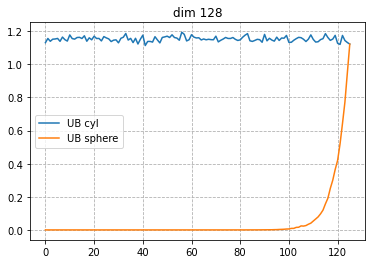

In [3]:
nr_samples = int(1e3)
dim = 128

x_sphere_small = torch.randn(nr_samples, 2).float().to(device)
x_sphere_small = x_sphere_small / torch.norm(x_sphere_small, dim=1, keepdim=True)

x_heights = torch.rand(nr_samples,dim-2).float().to(device)*2-1
x_cylinder = torch.cat([x_sphere_small, x_heights], dim=1)

x_sphere, ldj1 = T_c_to_s(x_cylinder)

upper_bounds_sphere = 2*torch.std(x_sphere[:,2:],dim=0).cpu().detach().numpy()
upper_bounds_cyl = 2*torch.std(x_heights,dim=0).cpu().detach().numpy()

plt.grid(linestyle='--')
plt.title(f'dim {dim}')
plt.plot(range(dim-2),np.array(upper_bounds_cyl),label=f'UB cyl')
plt.plot(range(dim-2),np.array(upper_bounds_sphere),label=f'UB sphere')

plt.legend()
plt.show()

### invertibility check from sphere to cylinder and back

this direction works perfectly even in higher dimensions, meaning we have good reconstructed inputs

In [4]:
TRAIN_SAMPLES = 200000
dim = 128

torch.set_printoptions(precision=4)
nr_samples = int(1e4)
dim = 128

torch.manual_seed(42)
mu_list, k_list, phi_mu_list, theta_mu_list = create_random_parameters(4, num_dim_data = dim)



In [5]:

power_spherical_data = PowerSphericalData(mu_list=mu_list, k_list=k_list, nr_samples=TRAIN_SAMPLES)

train_loader = DataLoader(power_spherical_data, batch_size=int(1e4), shuffle=True)

Secs for entropy calc 13.055743932723999
With entropy -127.26307678222656


In [6]:


for idx, x_sphere in enumerate(train_loader):
    
    
    print(idx)
    x_sphere = x_sphere.to(device)
    
    
    # sampling uniform samples
    # x_sphere = torch.randn(nr_samples, dim).to(device)
    # x_sphere = x_sphere / torch.norm(x_sphere, dim=1, keepdim=True)

    
    x_cyl, ldj2, sum_squares = T_s_to_c(x_sphere)

    
    torch.set_printoptions(precision=20)    
    
    sphere = x_cyl[:, :2]
    heights = x_cyl[:, 2:]
    
    print()
    print('after unfolding')
    print()
    
    if sphere.max() > 1 or sphere.min() < -1:
        torch.set_printoptions(profile="full")
        print('in sphere')
        print(sphere.max())
        print(sphere.min())
        print('sum squares.min()', sum_squares.min())
        print('sum squares.max()', sum_squares.max())        


    if heights.max() > 1 or heights.min() < -1:
        print('in heights')    
        print(heights.max())
        print(heights.min()) 
        print('sum_squares', sum_squares)
        
        print('heights greater 1',heights[heights>1].shape)
        print('heights smaller -1',heights[heights<-1].shape)        




0

after unfolding

in sphere
tensor(1.0010, device='cuda:0')
tensor(-1.0005, device='cuda:0')
sum squares.min() tensor(0.0006, device='cuda:0')
sum squares.max() tensor(1., device='cuda:0')
1

after unfolding

in sphere
tensor(1.0021, device='cuda:0')
tensor(-1.0345, device='cuda:0')
sum squares.min() tensor(0.0013, device='cuda:0')
sum squares.max() tensor(1., device='cuda:0')
2

after unfolding

in sphere
tensor(1.0220, device='cuda:0')
tensor(-1.0012, device='cuda:0')
sum squares.min() tensor(0.0012, device='cuda:0')
sum squares.max() tensor(1., device='cuda:0')
3

after unfolding

in sphere
tensor(1.0002, device='cuda:0')
tensor(-1.0001, device='cuda:0')
sum squares.min() tensor(0.0010, device='cuda:0')
sum squares.max() tensor(1., device='cuda:0')
4

after unfolding

in sphere
tensor(1.0001, device='cuda:0')
tensor(-1.0004, device='cuda:0')
sum squares.min() tensor(0.0017, device='cuda:0')
sum squares.max() tensor(1., device='cuda:0')
5

after unfolding

in sphere
tensor(1.0002, 

In [7]:
class Clamp(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input_,lower, upper):
        return input_.clamp(min=lower, max=upper)

    @staticmethod
    def backward(ctx, grad_output):
        print('grad_output',grad_output)
        return grad_output.clone(), None, None

custom_clamp = Clamp.apply


In [8]:
x_test = torch.randn(5,requires_grad=True)
x_test = torch.tensor(float('nan'),requires_grad=True)
print(x_test)

# y = torch.clamp(x_test,-1,1)
y = custom_clamp(x_test,-1, 1)

z = torch.sum(y)
z.backward()

print(y)
print(x_test.grad)

tensor(nan, requires_grad=True)
grad_output tensor(1.)
tensor(nan, grad_fn=<ClampBackward>)
tensor(1.)


In [9]:
x_test = torch.tensor(float('nan'),requires_grad=True)
x_test.clamp(-1,1)

tensor(nan, grad_fn=<ClampBackward>)

### check average interval size

input equal output True
ldjs are equal True
norm of sphere after True



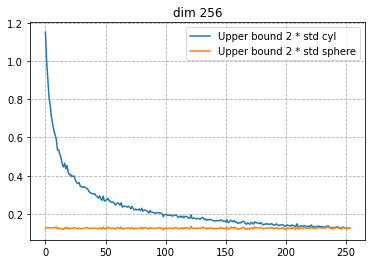

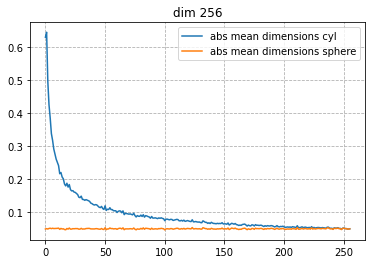

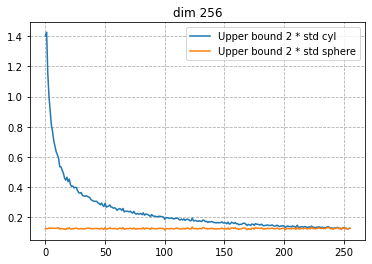

max and min heights 0.997702956199646 -0.9993230104446411


In [20]:


torch.set_printoptions(precision=4)

nr_samples = int(1e3)

dim = 256

# create sphere
x_sphere = torch.randn(nr_samples, dim).to(device)
x_sphere = x_sphere / torch.norm(x_sphere, dim=1, keepdim=True)

# to cylinder
x_cyl, ldj2 = T_s_to_c_new_with_ldj(x_sphere)

out1, ldj1 = T_c_to_s(x_cyl)

print(f'input equal output {torch.isclose(out1, x_sphere,atol=1e-5).all()}',)
print(f'ldjs are equal {torch.isclose(ldj1+ldj2,torch.tensor(0.),atol=1e-3).all()}')
print(f'norm of sphere after {torch.isclose(torch.norm(out1,dim=1),torch.tensor(1.)).all()}')
print()

x_heights = x_cyl[:,2:]

upper_bounds_cyl = 2*torch.std(x_heights,dim=0).cpu().detach().numpy()
upper_bounds_sphere = 2*torch.std(x_sphere[:,2:],dim=0).cpu().detach().numpy()
# upper_bounds_sphere_recon = 2*torch.std(x_sphere_recon[:,2:],dim=0).cpu().detach().numpy()

means_cyl = torch.mean(torch.abs(x_cyl),dim=0).cpu().detach().numpy()
means_sphere = torch.mean(torch.abs(x_sphere),dim=0).cpu().detach().numpy()

# plt.ylim(0.025, 0.7)

# only heights 
plt.grid(linestyle='--')
plt.title(f'dim {dim}')
plt.plot(range(dim-2),np.array(upper_bounds_cyl),label=f'Upper bound 2 * std cyl')
plt.plot(range(dim-2),np.array(upper_bounds_sphere),label=f'Upper bound 2 * std sphere')
    
plt.legend()
plt.show()
    
plt.grid(linestyle='--')
plt.title(f'dim {dim}')
plt.plot(range(dim),np.array(means_cyl),label=f'abs mean dimensions cyl')
plt.plot(range(dim),np.array(means_sphere),label=f'abs mean dimensions sphere')
    
plt.legend()
plt.show()
  
# all components
upper_bounds_cyl_2 = 2*torch.std(x_cyl,dim=0).cpu().detach().numpy()
upper_bounds_sphere_2 = 2*torch.std(x_sphere,dim=0).cpu().detach().numpy()
# upper_bounds_sphere_recon = 2*torch.std(x_sphere_recon[:,2:],dim=0).cpu().detach().numpy()
    
plt.grid(linestyle='--')
plt.title(f'dim {dim}')
plt.plot(range(dim),np.array(upper_bounds_cyl_2),label=f'Upper bound 2 * std cyl')
plt.plot(range(dim),np.array(upper_bounds_sphere_2),label=f'Upper bound 2 * std sphere')
    
plt.legend()
plt.show()
    
print(f'max and min heights {x_heights.max()} {x_heights.min()}')

In [23]:
x_cyl[:,:2]

tensor([[ 8.6258e-01, -5.0592e-01],
        [-8.2669e-01,  5.6267e-01],
        [ 5.9800e-01, -8.0149e-01],
        [-2.7491e-01, -9.6146e-01],
        [ 1.3180e-01,  9.9128e-01],
        [-3.2053e-01,  9.4681e-01],
        [-3.3147e-01, -9.4346e-01],
        [-9.9900e-01, -4.3322e-02],
        [-9.9997e-01, -7.5035e-03],
        [ 9.5968e-01, -2.8055e-01],
        [ 1.3830e-01, -9.9045e-01],
        [-9.1338e-01,  4.0719e-01],
        [ 3.1680e-01, -9.4849e-01],
        [-9.9838e-01,  5.6784e-02],
        [-3.6472e-01,  9.3106e-01],
        [ 8.3330e-01, -5.5288e-01],
        [-9.9742e-01, -7.1690e-02],
        [ 8.9354e-01, -4.4897e-01],
        [-8.2291e-01, -5.6817e-01],
        [ 6.1089e-01, -7.9171e-01],
        [ 9.0797e-01, -4.1902e-01],
        [-7.0065e-01, -7.1351e-01],
        [-9.9824e-01,  5.9304e-02],
        [ 8.9491e-01,  4.4621e-01],
        [ 9.9377e-01, -1.1144e-01],
        [-8.9126e-01, -4.5350e-01],
        [-9.8687e-01, -1.6191e-01],
        [-9.7445e-01, -2.244

### timing check of vectorized vs unvectorized

In [ ]:
# for i in range(2,11):
#     nr_samples = int(5)
#     dim = 2 ** i
#     print(dim)
#     x_sphere = torch.randn(nr_samples, dim).to(device)
#     x_sphere = x_sphere / torch.norm(x_sphere, dim=1, keepdim=True)

#     import time 
#     start_time = time.time()
#     out1, ldj1 = T_s_to_c(x_sphere)
#     time_1 = time.time()-start_time
#     print(f'time elapsed for classic {time_1}')

#     start_time = time.time()
#     out2, ldj2 = T_s_to_c_new_with_ldj(x_sphere)
#     time_2 = time.time()-start_time
#     print(f'time elapsed {time_2}')

#     print('output close sum', torch.sum(torch.isclose(out1,out2)))
#     print('ldj close sum', torch.sum(torch.isclose(ldj1,ldj2)))

#     print(time_1 / time_2)
#     print()

### fit model of small interval size to ISF

In [ ]:
# torch.randn(batch_size,1).to(device)*0.1

# from code import *
# import torch.optim as optim

# batch_size = 1024*2
# num_bins = 12
# HIDDEN_DIM_SPLINE_MLP = 128
# iters_per_epoch = 50
# epochs = 15


# ISF = Interval_Spline_Flow(num_bins=num_bins,
#                           num_dim=1,
#                           num_dim_conditioner=None,
#                           num_hidden=HIDDEN_DIM_SPLINE_MLP)

# optimizer = optim.AdamW(ISF.parameters())

# ISF.to(device)

# for epoch in range(epochs):
#     for _ in range(iters_per_epoch):

#         optimizer.zero_grad()
#         x_train = torch.rand(batch_size,1).to(device)*0.2-0.1
# #         x_train = torch.normal(0,0.1,(batch_size,1)).to(device)

#         out, ldj = ISF(x_train)
#         torch.mean(-ldj).backward()
#         optimizer.step()
        
#     print('Epoch', epoch)
#     x_linspace = torch.linspace(-0.2,0.2,1000).view(-1,1).to(device)
#     out_eval, ldj_eval = ISF(x_linspace)
#     print(torch.mean(torch.exp(ldj_eval)))

#     plt.plot(x_linspace.cpu().detach().numpy(),torch.exp(ldj_eval).cpu().detach().numpy())
#     plt.show()

### jacobian autograd testing

In [ ]:
# test with some dummy data

dim = 3

jac = torch.zeros(dim,dim)

for i in range(dim):
    z = torch.ones(dim, requires_grad=True)
    x = 2 * z
    e1 = torch.zeros(dim)
    
    e1[i] = 1
    
    y = torch.ones(dim)
    y[0] = x[0] ** 2
    y[1] = x[1] ** 3 
    y[2] = x[2] ** 4    
    
    y.backward(e1,retain_graph = True)
    
    jac_row = z.grad

    jac[i] = jac_row
    
print(jac)    
torch.det(jac)


### jacobian calculation 

In [ ]:
dim = 3

jac = torch.zeros(dim,dim)
nr_samples = 1
rand_int = torch.randint(int(1e2),(1,))

for i in range(dim):
    
    torch.manual_seed(rand_int)
#     torch.manual_seed(5)
    
    x_sphere_ = torch.randn(1, dim, device=device)
    x_sphere = x_sphere_ / torch.norm(x_sphere_, dim=1, keepdim=True)   
    
    if i == 0:
        print(f'x_sphere {x_sphere.squeeze()}')
        print()
              
    x_sphere.requires_grad = True
    
    e1 = torch.zeros(dim).to(device)
    
    e1[i] = 1

    x_cyl, ldj2 = T_s_to_c_new_with_ldj(x_sphere)
    x_cyl = x_cyl.squeeze()
    x_cyl.squeeze().backward(e1)
    
    jac_row = x_sphere.grad
    
    print(f'i {i} jac_row {jac_row}')
    
    jac[i] = jac_row
    
print()
print(jac)    
print()
print(torch.det(jac))


### get E matrix in 3 dimensions for jacobian calculation 

In [ ]:
def get_E_3dim(x_sphere):

    x, y, z = x_sphere[:,0], x_sphere[:,1], x_sphere[:,2]

    theta = torch.asin(z)
    phi = torch.atan2(y,x)

    e1 = torch.zeros(3)
    e2 = torch.zeros(3)

    e1[0] = - torch.sin(phi) * torch.cos(theta)
    e1[1] = torch.cos(phi) * torch.cos(theta)
    e1[2] = 0

    e1 = e1 / torch.norm(e1, keepdim=True)

    e2[0] = - torch.cos(phi) * torch.sin(theta)
    e2[1] = - torch.sin(phi) * torch.sin(theta)
    e2[2] = torch.cos(theta)

    e2 = e2 / torch.norm(e2, keepdim=True)

    return torch.cat([e1.view(-1,1),e2.view(-1,1)],dim=1)



E = get_E_3dim(x_sphere)

print(E)

JE = torch.matmul(jac, E)

G = torch.matmul(JE.T,JE)

print(G)
torch.det(G)

In [ ]:
def get_E_4d():

    phi_12 = torch.rand(2).to(device)*np.pi

    phi_1 = phi_12[0] 
    phi_2 = phi_12[1] 

    phi_3 = torch.rand(1).to(device)*2*np.pi

    x_sphere = torch.zeros(4).to(device) 

    x_sphere[0] = torch.cos(phi_1)
    x_sphere[1] = torch.sin(phi_1) * torch.cos(phi_2)
    x_sphere[2] = torch.sin(phi_1) * torch.sin(phi_2) * torch.cos(phi_3)
    x_sphere[3] = torch.sin(phi_1) * torch.sin(phi_2) * torch.sin(phi_3)

    x_sphere = x_sphere.view(-1,1)

    e1 = torch.zeros(4)
    e2 = torch.zeros(4)
    e3 = torch.zeros(4)

    e1[0] = - torch.sin(phi_1)
    e1[1] = torch.cos(phi_1) * torch.cos(phi_2)
    e1[2] = torch.cos(phi_1) * torch.sin(phi_2) * torch.cos(phi_3)
    e1[3] = torch.cos(phi_1) * torch.sin(phi_2) * torch.sin(phi_3)

    e2[0] = 0
    e2[1] = - torch.sin(phi_1) * torch.sin(phi_2)
    e2[2] = torch.sin(phi_1) * torch.cos(phi_2) * torch.cos(phi_3)
    e2[3] = torch.sin(phi_1) * torch.cos(phi_2) * torch.sin(phi_3)

    e3[0] = 0
    e3[1] = 0
    e3[2] = - torch.sin(phi_1) * torch.sin(phi_2) * torch.sin(phi_3)
    e3[3] = torch.sin(phi_1) * torch.sin(phi_2) * torch.cos(phi_3)
    
    e1 = e1 / torch.norm(e1, keepdim=True)
    e2 = e2 / torch.norm(e2, keepdim=True)
    e3 = e3 / torch.norm(e3, keepdim=True)
    
    E = torch.cat([e1.view(-1,1),e2.view(-1,1), e3.view(-1,1)], dim=1)

    return x_sphere.view(1,-1), E 



In [ ]:

dim = 4
jac = torch.zeros(dim,dim)
rand_int = torch.randint(int(1e2),(1,))

for i in range(dim):
    
    torch.manual_seed(rand_int)
    
    x_sphere, E = get_E_4d() 
    
    if i == 0:
        
        print(f'x_sphere {x_sphere.squeeze()}')
        print()
              
    x_sphere.requires_grad = True
    
    e1 = torch.zeros(dim).to(device)
    
    e1[i] = 1

    x_cyl, ldj2 = T_s_to_c_new_with_ldj(x_sphere)
    
    x_cyl = x_cyl.squeeze()
    x_cyl.squeeze().backward(e1)
    
    jac_row = x_sphere.grad
    
    jac[i] = jac_row
 
print()
print('E',E)
print()
print('jac',jac)
JE = torch.matmul(jac, E)

G = torch.matmul(JE.T,JE)
print()
print('ldj2',ldj2)
torch.log(torch.sqrt(torch.det(G)))

### jacobian calculation for T_c_to_s

In [ ]:
dim = 3

jac = torch.zeros(dim,dim)

for i in range(dim):
    
    torch.manual_seed(torch.randint(int(1e2),(1,)))
    
    x_sphere_ = torch.randn(nr_samples, 2, device=device)
    x_sphere = x_sphere_ / torch.norm(x_sphere_, dim=1, keepdim=True)   
    
    x_heights = torch.rand(nr_samples, dim-2, device=device)
    
    x_cyl = torch.cat([x_sphere,x_heights],dim=1)
    x_cyl.requires_grad = True
    
    e1 = torch.zeros(dim).to(device)
    
    e1[i] = 1

    x_sphere, ldj2 = T_c_to_s(x_cyl)
    
    x_sphere = x_sphere.squeeze()
    x_sphere.squeeze().backward(e1)
    
    jac_row = x_cyl.grad
    
    print(f'i {i} jac_row {jac_row}')
    
    jac[i] = jac_row
    
    
print()
print(jac)    

print(torch.det(jac))

E = torch.eye(3)[:, 1::]

print(E)

JE = torch.matmul(jac, E)
G = torch.matmul(JE.T, JE)

print(G)

torch.det(G)
